
===== FEATURE SUMMARY =====
Numeric: ['Area', 'Perimeter', 'Major_Axis_Length', 'Minor_Axis_Length', 'Convex_Area', 'Equiv_Diameter', 'Eccentricity', 'Solidity', 'Extent', 'Roundness', 'Aspect_Ration', 'Compactness']
Categorical: []


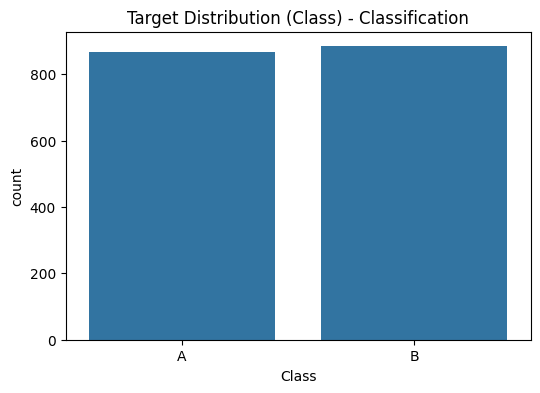

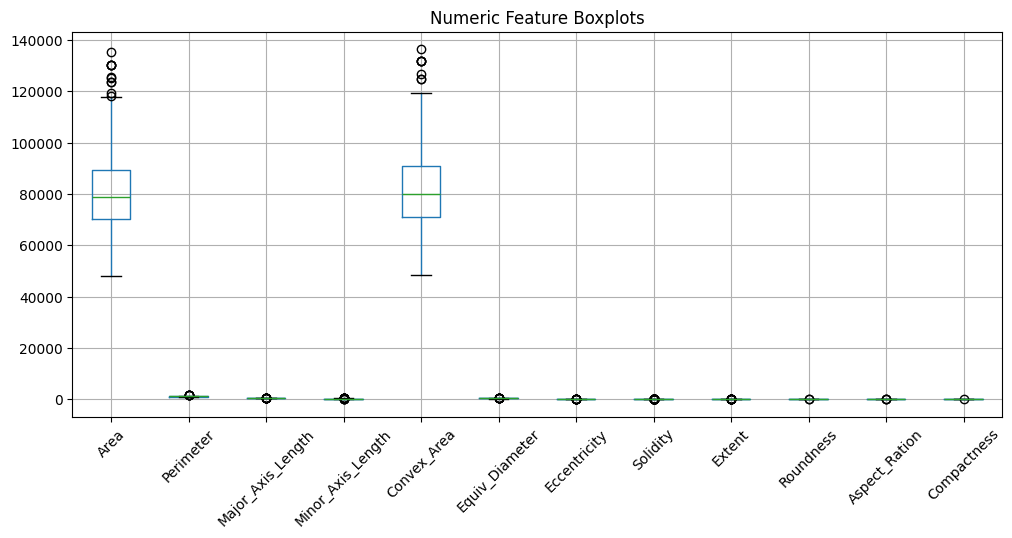

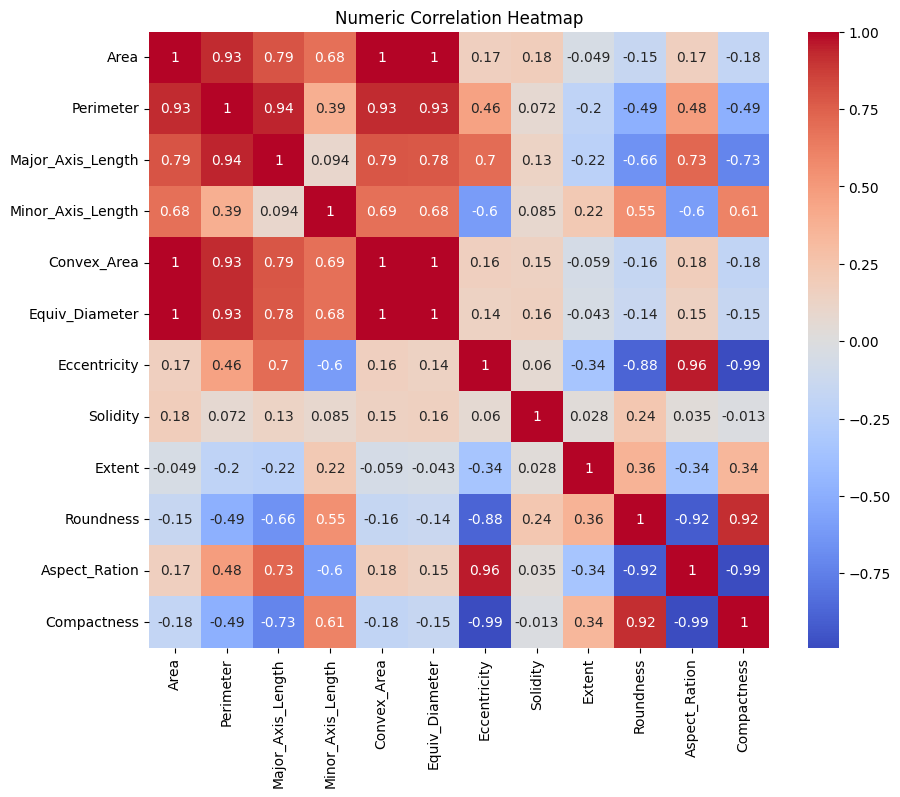


>>> Detected task: CLASSIFICATION

======= MODEL PERFORMANCE =======
Accuracy: 0.9259259259259259
F1 Score: 0.9258958575383853
ROC-AUC: 0.9669416120023382


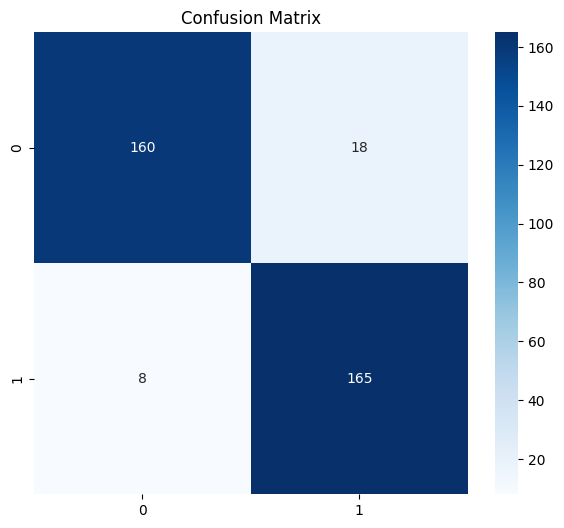


Generating permutation feature importance...


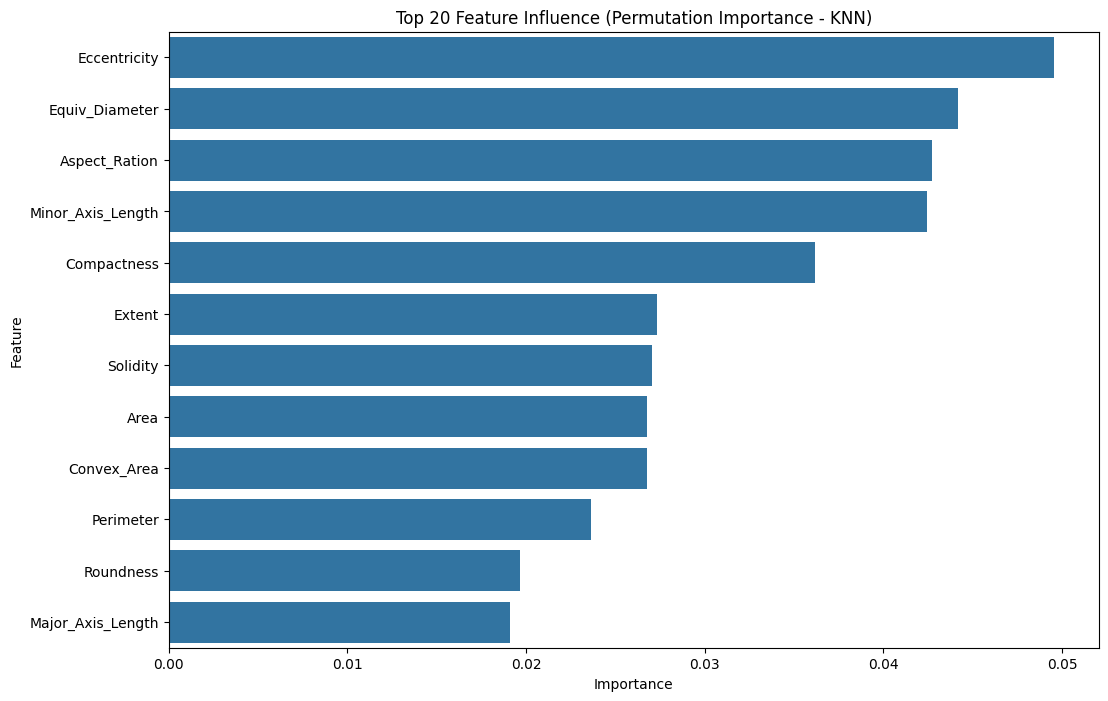


✔ submission_universal.csv saved

✔ result.csv saved
   id Status
0   1      B
1   2      B
2   3      B
3   4      A
4   5      A


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    mean_squared_error, r2_score, confusion_matrix
)
from sklearn.inspection import permutation_importance

REMOVE_OUTLIERS = True
VISUALIZE = True
RANDOM_STATE = 18

# ================= LOAD DATA ================= #
df = pd.read_csv('/content/train (2).csv')
target_col = df.columns[-1]

df = df.dropna(subset=[target_col])

X = df.drop(columns=[target_col])
y = df[target_col]

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include='object').columns.tolist()

print("\n===== FEATURE SUMMARY =====")
print("Numeric:", numeric_cols)
print("Categorical:", categorical_cols)

# TARGET VISUALIZATION
if VISUALIZE:
    plt.figure(figsize=(6,4))
    if y.dtype.kind in "O" or y.nunique() <= 20:
        sns.countplot(x=y)
        plt.title(f"Target Distribution ({target_col}) - Classification")
    else:
        sns.histplot(y, kde=True)
        plt.title(f"Target Distribution ({target_col}) - Regression")
    plt.show()

# BOX PLOTS
if VISUALIZE and numeric_cols:
    plt.figure(figsize=(12,5))
    X[numeric_cols].boxplot(rot=45)
    plt.title("Numeric Feature Boxplots")
    plt.show()

# CORRELATION HEATMAP
if VISUALIZE and len(numeric_cols) > 1:
    plt.figure(figsize=(10,8))
    sns.heatmap(X[numeric_cols].corr(), annot=True, cmap="coolwarm")
    plt.title("Numeric Correlation Heatmap")
    plt.show()

# CATEGORICAL COUNTS
if VISUALIZE:
    for col in categorical_cols:
        plt.figure(figsize=(6,4))
        sns.countplot(x=col, data=X, order=X[col].value_counts().index)
        plt.title(f"Counts of {col}")
        plt.xticks(rotation=45)
        plt.show()

# TASK DETECTION
def detect_task(y):
    if y.dtype.kind in "biufc" and y.nunique() > 20:
        return "regression"
    else:
        return "classification"

task_type = detect_task(y)
print(f"\n>>> Detected task: {task_type.upper()}")

# SPLIT
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

# OUTLIER REMOVAL
def remove_outliers_iqr(df, numeric_cols):
    df_clean = df.copy()
    for col in numeric_cols:
        Q1, Q3 = df_clean[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        low, high = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= low) & (df_clean[col] <= high)]
    return df_clean

if REMOVE_OUTLIERS and task_type == "regression":
    combined = X_train.copy()
    combined[target_col] = y_train
    cleaned = remove_outliers_iqr(combined, numeric_cols)

    print(f"Outlier removal: {combined.shape[0]} → {cleaned.shape[0]}")
    X_train = cleaned.drop(columns=[target_col])
    y_train = cleaned[target_col]

# LABEL ENCODING
if task_type == "classification":
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test = le.transform(y_test)

# PREPROCESSOR
def get_preprocessor(numeric_cols, categorical_cols):
    low_card = [c for c in categorical_cols if df[c].nunique() <= 20]
    high_card = [c for c in categorical_cols if df[c].nunique() > 20]

    return ColumnTransformer([
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="mean")),
            ("scaler", StandardScaler())
        ]), numeric_cols),

        ("cat_low", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ]), low_card),

        ("cat_high", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ord", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
        ]), high_card),
    ])

preprocessor = get_preprocessor(numeric_cols, categorical_cols)

# KNN MODEL
if task_type == "classification":
    model = KNeighborsClassifier(
        n_neighbors=7,
        weights="distance"
    )
else:
    model = KNeighborsRegressor(
        n_neighbors=7,
        weights="distance"
    )

pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", model)
])

pipeline.fit(X_train, y_train)

# EVALUATION
y_pred = pipeline.predict(X_test)

print("\n======= MODEL PERFORMANCE =======")
if task_type == "classification":
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred, average="weighted"))

    if hasattr(model, "predict_proba"):
        y_proba = pipeline.predict_proba(X_test)
        if y_proba.shape[1] > 2:
            print("ROC-AUC (OVR):", roc_auc_score(y_test, y_proba, multi_class="ovr"))
        else:
            print("ROC-AUC:", roc_auc_score(y_test, y_proba[:, 1]))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()

else:
    print("MSE:", mean_squared_error(y_test, y_pred))
    print("R2:", r2_score(y_test, y_pred))

# FEATURE IMPORTANCE (KNN)
print("\nGenerating permutation feature importance...")

X_test_trans = pipeline.named_steps["preprocess"].transform(X_test)

perm = permutation_importance(
    pipeline.named_steps["model"],
    X_test_trans,
    y_test,
    n_repeats=10,
    random_state=RANDOM_STATE,
    scoring="accuracy" if task_type == "classification" else "r2"
)

def get_feature_names(preprocessor):
    names = []
    for name, transformer, cols in preprocessor.transformers_:
        if transformer == "drop":
            continue
        if hasattr(transformer, "named_steps"):
            last = list(transformer.named_steps.values())[-1]
            if hasattr(last, "get_feature_names_out"):
                try:
                    names.extend(last.get_feature_names_out(cols))
                except:
                    names.extend(cols)
        else:
            names.extend(cols)
    return names

feature_names = get_feature_names(pipeline.named_steps["preprocess"])

feat_imp = pd.DataFrame({
    "Feature": feature_names,
    "Importance": perm.importances_mean
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(12,8))
sns.barplot(data=feat_imp.head(20), x="Importance", y="Feature")
plt.title("Top 20 Feature Influence (Permutation Importance - KNN)")
plt.show()

# LOAD TEST DATA
df_test = pd.read_csv('/content/test (1).csv')
test_ids = df_test["id"]

X_test_final = df_test.drop(columns=["id"], errors="ignore")

for col in X_train.columns:
    if col not in X_test_final.columns:
        X_test_final[col] = np.nan

X_test_final = X_test_final[X_train.columns]

# SUBMISSION FILES
if task_type == "classification":
    proba = pipeline.predict_proba(X_test_final)
    labels = le.inverse_transform(model.classes_)
    submission = pd.DataFrame(proba, columns=[f"Status_{l}" for l in labels])
else:
    pred_final = pipeline.predict(X_test_final)
    submission = pd.DataFrame({"Prediction": pred_final})

submission.insert(0, "id", test_ids)
submission.to_csv("submission_universal.csv", index=False)

print("\n✔ submission_universal.csv saved")

pred_labels = pipeline.predict(X_test_final)
submission2 = pd.DataFrame({
    "id": test_ids,
    "Status": le.inverse_transform(pred_labels)
})
submission2.to_csv("result.csv", index=False)

print("\n✔ result.csv saved")
print(submission2.head())
